In [19]:
from transformers import BertForMaskedLM
import pandas as pd
from geneformer.tokenizer import (
    GENE_MEDIAN_FILE, 
    TOKEN_DICTIONARY_FILE,
    tokenize_cell
)
import pickle
import glob
import numpy as np
from pathlib import Path
from datasets import Dataset

class GenericTranscriptomeTokenizer:
    def __init__(
        self,
        custom_attr_name_dict=None,
        nproc=1,
        gene_median_file=GENE_MEDIAN_FILE,
        token_dictionary_file=TOKEN_DICTIONARY_FILE,
    ):
        """
        Initialize tokenizer.
        Parameters
        ----------
        custom_attr_name_dict : dict
            Dictionary of custom attributes to be added to the dataset.
            Keys are the names of the attributes in the loom file.
            Values are the names of the attributes in the dataset.
        nproc : int
            Number of processes to use for dataset mapping.
        gene_median_file : Path
            Path to pickle file containing dictionary of non-zero median
            gene expression values across Genecorpus-30M.
        token_dictionary_file : Path
            Path to pickle file containing token dictionary (Ensembl IDs:token).
        """
        # dictionary of custom attributes {output dataset column name: input .loom column name}            
        self.custom_attr_name_dict = custom_attr_name_dict if custom_attr_name_dict is not None else {}

        # number of processes for dataset mapping
        self.nproc = nproc

        # load dictionary of gene normalization factors
        # (non-zero median value of expression across Genecorpus-30M)
        with open(gene_median_file, "rb") as f:
            self.gene_median_dict = pickle.load(f)

        # load token dictionary (Ensembl IDs:token)
        with open(token_dictionary_file, "rb") as f:
            self.gene_token_dict = pickle.load(f)

        # gene keys for full vocabulary
        self.gene_keys = list(self.gene_median_dict.keys())

        # protein-coding and miRNA gene list dictionary for selecting .loom rows for tokenization
        self.genelist_dict = dict(zip(self.gene_keys, [True] * len(self.gene_keys)))
        
        

    def tokenize_data(self, data_directory, file_type, output_directory=None, output_prefix="tokenized_txs"):
        """
        Tokenize .loom files in loom_data_directory and save as tokenized .dataset in output_directory.
        Parameters
        ----------
        loom_data_directory : Path
            Path to directory containing loom files
        output_directory : Path
            Path to directory where tokenized data will be saved as .dataset
        output_prefix : str
            Prefix for output .dataset
        """
        tokenized_cells, cell_metadata = self.tokenize_files(data_directory, file_type)
        tokenized_dataset = self.create_dataset(tokenized_cells, cell_metadata)
        
        if output_directory is not None:
            output_path = (Path(output_directory) / output_prefix).with_suffix(".dataset")
            tokenized_dataset.save_to_disk(output_path)
        return tokenized_dataset

    def tokenize_files(self, data_directory, file_type):
        tokenized_cells = []
        cell_metadata = {attr_key: [] for attr_key in self.custom_attr_name_dict.keys()}
        
        if file_type in ["csv", "tsv"]:
            cell_metadata["sample_id"] = []

        # loops through directories to tokenize .{file_type} files
        for file_path in glob.glob(f"{data_directory}/*.{file_type}"):
            print(f"Tokenizing {file_path}")
            file_tokenized_cells, file_cell_metadata = self.tokenize_file(
                file_path, 
                file_type
            )
            tokenized_cells += file_tokenized_cells
            for k in cell_metadata.keys():
                cell_metadata[k] += file_cell_metadata[k]

        return tokenized_cells, cell_metadata

    def tokenize_file(self, file_path, file_type):
        file_cell_metadata = {
            attr_key: [] for attr_key in self.custom_attr_name_dict.keys()
        }
        if file_type == "loom":
            with lp.connect(str(file_path)) as data:
                # define coordinates of detected protein-coding or miRNA genes and vector of their normalization factors
                coding_miRNA_loc = np.where(
                    [self.genelist_dict.get(i, False) for i in data.ra["ensembl_id"]]
                )[0]
                norm_factor_vector = np.array(
                    [
                        self.gene_median_dict[i]
                        for i in data.ra["ensembl_id"][coding_miRNA_loc]
                    ]
                )
                coding_miRNA_ids = data.ra["ensembl_id"][coding_miRNA_loc]
                coding_miRNA_tokens = np.array(
                    [self.gene_token_dict[i] for i in coding_miRNA_ids]
                )

                # define coordinates of cells passing filters for inclusion (e.g. QC)
                try:
                    data.ca["filter_pass"]
                except NameError:
                    var_exists = False
                else:
                    var_exists = True

                if var_exists is True:
                    filter_pass_loc = np.where(
                        [True if i == 1 else False for i in data.ca["filter_pass"]]
                    )[0]
                elif var_exists is False:
                    print(
                        f"{loom_file_path} has no column attribute 'filter_pass'; tokenizing all cells."
                    )
                    filter_pass_loc = np.array([i for i in range(data.shape[1])])

                # scan through .loom files and tokenize cells
                tokenized_cells = []
                for (_ix, _selection, view) in data.scan(items=filter_pass_loc, axis=1):
                    # select subview with protein-coding and miRNA genes
                    subview = view.view[coding_miRNA_loc, :]

                    # normalize by total counts per cell and multiply by 10,000 to allocate bits to precision
                    # and normalize by gene normalization factors
                    subview_norm_array = (
                        subview[:, :]
                        / subview.ca.n_counts
                        * 10_000
                        / norm_factor_vector[:, None]
                    )
                    # tokenize subview gene vectors
                    tokenized_cells += [
                        tokenize_cell(subview_norm_array[:, i], coding_miRNA_tokens)
                        for i in range(subview_norm_array.shape[1])
                    ]

                    # add custom attributes for subview to dict
                    for k in file_cell_metadata.keys():
                        file_cell_metadata[k] += subview.ca[k].tolist()
        elif file_type in ["csv", "tsv"]:
            df = pd.read_csv(file_path, sep="\t" if file_type == "tsv" else ",", index_col=0)
            # Assume genes are columns samples are rows
            df_genes = df.columns
            file_cell_metadata["sample_id"] = df.index.values.tolist()
            coding_miRNA_loc = np.where(
                    [self.genelist_dict.get(i, False) for i in df_genes]
            )[0]
            norm_factor_vector = np.array(
                [
                    self.gene_median_dict[i]
                    for i in df_genes[coding_miRNA_loc]
                ]
            )
            coding_miRNA_ids = df_genes[coding_miRNA_loc]
            coding_miRNA_tokens = np.array(
                [self.gene_token_dict[i] for i in coding_miRNA_ids]
            )
            
            tokenized_cells = []
            for _, row in df.iterrows():
                # select slice with protein-coding and miRNA genes
                _row = row[coding_miRNA_ids]

                # normalize by total counts per cell and multiply by 10,000 to allocate bits to precision
                # and normalize by gene normalization factors
                norm_row = (
                    _row
                    / _row.sum()
                    * 10_000
                    / norm_factor_vector
                )
                # tokenize subview gene vectors
                tokenized_cells.append(
                    tokenize_cell(norm_row.values, coding_miRNA_tokens)
                )

        return tokenized_cells, file_cell_metadata

    def create_dataset(self, tokenized_cells, cell_metadata):
        # create dict for dataset creation
        dataset_dict = {"input_ids": tokenized_cells}
        dataset_dict.update(cell_metadata)

        # create dataset
        output_dataset = Dataset.from_dict(dataset_dict)

        # truncate dataset
        def truncate(example):
            example["input_ids"] = example["input_ids"][0:2048]
            return example

        output_dataset_truncated = output_dataset.map(truncate, num_proc=self.nproc)

        # measure lengths of dataset
        def measure_length(example):
            example["length"] = len(example["input_ids"])
            return example

        output_dataset_truncated_w_length = output_dataset_truncated.map(
            measure_length, num_proc=self.nproc
        )

        return output_dataset_truncated_w_length
    

tokenizer = GenericTranscriptomeTokenizer()
dataset = tokenizer.tokenize_data("depmap", "csv")
dataset

Tokenizing depmap/depmap_expression_ensg_test.csv



Map:   0%|                                                                                                                     | 0/5 [00:00<?, ? examples/s]
                                                                                                                                                            
Map:   0%|                                                                                                                     | 0/5 [00:00<?, ? examples/s]
                                                                                                                                                            

Dataset({
    features: ['input_ids', 'sample_id', 'length'],
    num_rows: 5
})

In [20]:
dataset = tokenizer.tokenize_data("depmap/expression/", "csv", output_directory="depmap/expression/huggingface_dataset/")

Tokenizing depmap/expression/depmap_expression_ensg.csv



Map: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████▌| 1444/1450 [00:05<00:00, 263.48 examples/s]
                                                                                                                                                            
Map:  89%|█████████████████████████████████████████████████████████████████████████████████████████▉           | 1291/1450 [00:00<00:00, 1481.75 examples/s]
                                                                                                                                                            
Saving the dataset (1/1 shards): 100%|███████████████████████████████████████████████████████████████████████| 1450/1450 [00:00<00:00, 201435.51 examples/s]
                                                                                                                                                            

In [21]:
dataset

Dataset({
    features: ['input_ids', 'sample_id', 'length'],
    num_rows: 1450
})

In [24]:
from utils import GENE2ENSEMBLE
import random

with open("genes_to_perturb.pkl", "rb") as fl:
    genes_to_perturb = pickle.load(fl)

with open(TOKEN_DICTIONARY_FILE, "rb") as fl:
    token_dict = pickle.load(fl)
    
genes_to_perturb = [g for g in genes_to_perturb if GENE2ENSEMBLE[g] in token_dict]
random.seed(123)
random.shuffle(genes_to_perturb)
len(genes_to_perturb)

17537

In [40]:

def perturb_gene(gexp_tokenized_list, gene, min_idx=100):
    perturbed = gexp_tokenized_list.copy()
    try:
        idx = perturbed.index(token_dict[GENE2ENSEMBLE[gene]])
    except ValueError:
        return
    if idx is not None and idx <= min_idx:
        del perturbed[idx]
        perturbed.append(token_dict['<pad>'])
        return perturbed
    else:
        return
    

def perturb_dataset(dataset, genes_to_perturb):
    perturbed_sample_ids = []
    perturbed_gexps = []
    for sid, gexp_tokenized_list in zip(dataset["sample_id"], dataset["input_ids"]):
        perturbed_gexps.append(gexp_tokenized_list)
        perturbed_sample_ids.append(sid)
        for g in genes_to_perturb:
            perturbed_gexp = perturb_gene(gexp_tokenized_list, g)
            if perturbed_gexp is not None:
                perturbed_gexps.append(perturbed_gexp)
                perturbed_sample_ids.append(sid + f"|perturbed|{g}")
            
    # create dict for dataset creation
    dataset_dict = {"input_ids": perturbed_gexps, "sample_id": perturbed_sample_ids}

    # create dataset
    output_dataset = Dataset.from_dict(dataset_dict)

    # truncate dataset
    def truncate(example):
        example["input_ids"] = example["input_ids"][0:2048]
        return example

    output_dataset_truncated = output_dataset.map(truncate, num_proc=1)

    # measure lengths of dataset
    def measure_length(example):
        example["length"] = len(example["input_ids"])
        return example

    output_dataset_truncated_w_length = output_dataset_truncated.map(
        measure_length, num_proc=1
    )

    return output_dataset_truncated_w_length


perturbed_dataset = perturb_dataset(dataset, genes_to_perturb[:500])
perturbed_dataset


Map: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████▌| 7448/7484 [00:05<00:00, 1637.86 examples/s]
                                                                                                                                                            
Map:  98%|██████████████████████████████████████████████████████████████████████████████████████████████████▉  | 7328/7484 [00:04<00:00, 1601.14 examples/s]
                                                                                                                                                            

Dataset({
    features: ['input_ids', 'sample_id', 'length'],
    num_rows: 7484
})

In [41]:
model = BertForMaskedLM.from_pretrained("ctheodoris/Geneformer", 
                                        output_hidden_states=True, 
                                        output_attentions=False)

In [42]:
import torch
from tqdm import tqdm
def get_likelihoods(dataset, model):
    samples = torch.tensor(dataset["input_ids"])
    B = samples.shape[0]
    N = samples.shape[1]
    batch_size = 5
    likelihoods = []
    for i in tqdm(range(0, B, batch_size), position=0, leave=True):
        batch = samples[i:i+batch_size, :]
        with torch.no_grad():
            output = model(input_ids=batch)
        ls = torch.log_softmax(output.logits, dim=-1)

        likelihoods += [ls[j, range(N), batch[j, :]].sum().numpy() for j in range(batch.shape[0])]
    return {sid: l for sid, l in zip(dataset["sample_id"], likelihoods)}

likelihoods = get_likelihoods(perturbed_dataset, model)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1497/1497 [58:28<00:00,  2.34s/it]


In [44]:
pd.DataFrame({'a':{1:2, 3:4}})

,a
1,2
3,4


In [80]:
from collections import defaultdict
def generate_scoring_matrix(likelihoods, ratio=True):
    mat = defaultdict(dict)
    for k, v in likelihoods.items():
        if 'perturbed' in k:
            cellline, _, gene = k.split('|')
            if ratio:
                mat[gene][cellline] = likelihoods[cellline] - v
            else:
                mat[gene][cellline] = v
    return pd.DataFrame(mat)

zero_shot_scoring_matrix = generate_scoring_matrix(likelihoods)
zero_shot_scoring_matrix_no_ratio = generate_scoring_matrix(likelihoods, ratio=False)

In [72]:
zero_shot_scoring_matrix.to_csv("zero_shot_scoring_matrix.csv")

In [73]:
crispr_df = pd.read_csv("depmap/crispr/CRISPRGeneEffect.csv", index_col=0)
crispr_df.columns = [x.split()[0] for x in crispr_df.columns]
crispr_df

,A1BG,A1CF,A2M,A2ML1,A3GALT2,A4GALT,A4GNT,AAAS,AACS,AADAC,...,ZWILCH,ZWINT,ZXDA,ZXDB,ZXDC,ZYG11A,ZYG11B,ZYX,ZZEF1,ZZZ3
ModelID,,,,,,,,,,,,,,,,,,,,,
ACH-000001,-0.102725,0.058595,0.058246,-0.041881,-0.088661,0.170335,-0.015254,-0.223691,0.218612,0.025719,...,-0.084055,-0.084184,0.131495,0.238702,0.201712,-0.250381,0.045612,0.044154,0.146801,-0.473583
ACH-000004,0.008878,-0.077633,-0.099297,0.030120,-0.080334,-0.112404,0.298774,-0.125139,0.218675,0.222941,...,-0.066673,-0.443145,0.183618,0.058936,0.108711,0.056322,-0.355712,0.135310,0.200408,-0.076150
ACH-000005,-0.117950,0.013989,0.164099,0.184570,-0.201766,-0.202198,0.207814,-0.089192,-0.082624,0.119679,...,-0.151588,-0.402572,-0.073320,-0.114402,-0.009449,-0.198378,-0.135007,0.014708,-0.065341,-0.196296
ACH-000007,-0.049135,-0.089991,0.084994,0.129586,-0.041561,-0.014555,0.045143,-0.263324,-0.135143,0.229040,...,-0.273444,-0.533265,-0.016257,0.222234,0.086937,-0.070598,-0.412361,-0.003722,-0.277756,-0.410805
ACH-000009,0.004969,-0.098170,0.092887,0.110913,0.028599,-0.087008,0.073032,-0.240147,0.072294,0.112749,...,-0.212287,-0.326986,-0.037498,0.235983,-0.070229,-0.061208,-0.537773,0.084630,0.018678,-0.307176
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ACH-002800,-0.000591,-0.118200,0.264553,0.117171,-0.323325,0.076171,0.025801,-0.115184,-0.155542,0.106708,...,0.159245,-0.301424,-0.031900,0.297571,-0.050877,-0.066423,-0.280812,-0.085753,-0.074035,-0.099549
ACH-002834,-0.046332,-0.105593,0.072203,0.058669,-0.254654,-0.046796,0.114660,-0.637864,0.090588,0.174153,...,-0.069967,-0.671956,-0.053672,-0.071521,-0.058631,0.028762,0.052414,-0.320080,-0.105069,-0.557717
ACH-002847,-0.036301,-0.074850,0.052350,0.097964,-0.150341,0.034993,0.114026,-0.401955,-0.037905,0.089964,...,-0.313018,-0.958124,0.123488,0.130380,0.046296,-0.054613,-0.220010,-0.212531,-0.092958,-0.486332


In [74]:
crispr_df_to_compare = crispr_df.copy()
crispr_df_to_compare = crispr_df_to_compare[zero_shot_scoring_matrix.columns]
crispr_df_to_compare = crispr_df_to_compare.loc[[x for x in zero_shot_scoring_matrix.index.values if x in crispr_df.index.values]]
zero_shot_scoring_matrix_to_compare = zero_shot_scoring_matrix.loc[[x for x in crispr_df_to_compare.index.values if x in zero_shot_scoring_matrix.index.values]]
crispr_df_to_compare

,PSMD9,MRPL38,TXNDC5,SLC39A7,ITGB4,CCDC51,AJUBA,IRAK1,TMEM54,ABHD11,...,TRIM58,EXOSC7,TIMM17A,SSC4D,HSD17B2,TMEM45B,PLRG1,DPM1,TUBA1C,ENDOG
ModelID,,,,,,,,,,,,,,,,,,,,,
ACH-001289,-0.358486,-0.509362,0.038917,-0.910470,-0.045457,-0.075469,0.153109,0.025889,0.002777,-0.232722,...,0.251185,-0.875174,-0.202174,-0.152884,0.434552,-0.048943,-0.731781,-0.015745,-0.137302,-0.039162
ACH-001538,-0.100114,-0.474683,0.216577,-1.417156,-0.155714,0.040495,0.624297,0.067869,-0.111799,-0.288033,...,0.371306,-0.828157,-0.232623,-0.233811,0.231737,0.220144,-0.731030,-0.163273,-0.989186,-0.502975
ACH-000233,-0.443380,-0.799362,0.177809,-0.821093,-0.209644,-0.104939,-0.054790,0.116835,-0.032585,-0.213189,...,0.026572,-1.258143,-0.389577,0.013233,0.244239,0.105021,-0.864848,-0.171173,-0.613524,-0.222553
ACH-000461,-0.389557,-1.108208,0.203085,-0.994310,-0.257761,-0.204224,-0.027331,0.096256,0.148976,-0.422194,...,0.226677,-0.982967,-0.657835,-0.100588,0.254114,0.219490,-0.738169,-0.266618,-1.565413,-0.576487
ACH-001794,-0.242602,-0.318265,0.155219,-1.063471,-0.172757,-0.164461,0.181463,0.029884,-0.221114,-0.199212,...,0.187294,-0.877569,-0.569059,-0.280195,0.182662,0.114069,-1.394549,-0.325990,-1.374892,-0.331273
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ACH-000387,-0.029628,-0.677952,0.128714,-0.587987,-0.112906,-0.239973,-0.090115,-0.172939,-0.079853,-0.413563,...,0.135323,-0.958044,-0.810810,-0.156823,0.237334,0.006621,-0.973023,-0.278597,-0.661499,-0.193117
ACH-001603,-0.386397,-0.579755,0.235191,-0.790372,-0.373990,-0.049883,0.098296,-0.100611,-0.173183,-0.293678,...,0.069098,-0.602189,-0.078465,-0.111115,0.297086,0.386066,-0.924554,0.229094,NaN,-0.560803
ACH-002080,-0.522949,-1.224166,0.114396,-0.529176,-0.063705,-0.240184,-0.235536,0.137796,-0.162914,-0.193084,...,0.214518,-1.360063,-0.086020,-0.062275,0.237876,0.058517,-1.268702,0.104018,-0.693195,-0.341472


In [81]:
zero_shot_scoring_matrix_no_ratio_to_compare = zero_shot_scoring_matrix_no_ratio.loc[[x for x in crispr_df_to_compare.index.values if x in zero_shot_scoring_matrix_no_ratio.index.values]]


Text(0, 0.5, 'Geneformer likelihood ratio\n (unperturbed vs perturbed)')

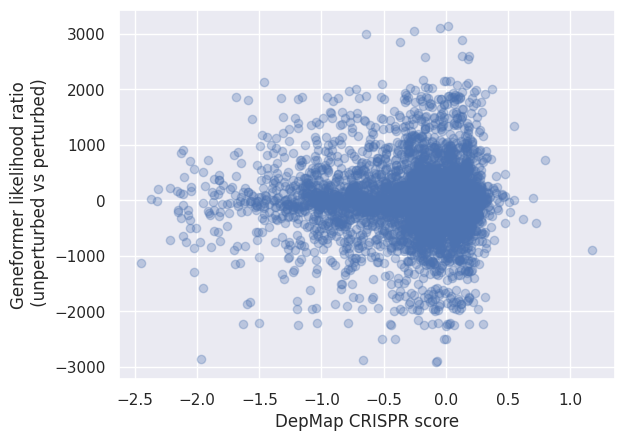

In [96]:
from matplotlib import pyplot as plt
import seaborn as sns

plt.scatter(
    crispr_df_to_compare[zero_shot_scoring_matrix_to_compare.notnull()].values.ravel(),
    zero_shot_scoring_matrix_to_compare.values.ravel(),
    alpha=0.3
)

plt.xlabel("DepMap CRISPR score")
plt.ylabel("Geneformer likelihood ratio\n (unperturbed vs perturbed)")

Text(0, 0.5, 'Geneformer likelihood \n (perturbed)')

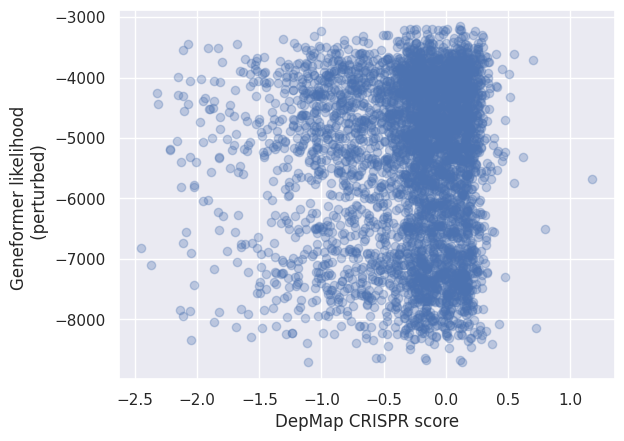

In [95]:
plt.scatter(
    crispr_df_to_compare[zero_shot_scoring_matrix_no_ratio_to_compare.notnull()].values.ravel(),
    zero_shot_scoring_matrix_no_ratio_to_compare.values.ravel(),
    alpha=0.3
)

plt.xlabel("DepMap CRISPR score")
plt.ylabel("Geneformer likelihood \n (perturbed)")

In [67]:
torch.log_softmax(output.logits, dim=-1)

tensor([[[-23.1001, -34.5579,  -9.1084,  ..., -17.1373, -16.5247, -22.2942],
         [-23.1712, -35.4161,  -8.6474,  ..., -17.1430, -16.5991, -22.6768],
         [-23.1980, -36.0589,  -8.3384,  ..., -17.2093, -16.3764, -22.7582],
         ...,
         [-23.9251, -37.5456,  -9.2354,  ..., -20.3903, -18.3909, -21.4798],
         [-19.6140, -34.6622,  -9.2514,  ..., -17.2557, -13.3906, -22.0211],
         [-20.7598, -35.3806, -12.2002,  ..., -18.2089, -14.1156, -23.0851]],

        [[-23.1953, -35.7664, -10.2419,  ..., -17.8950, -17.4716, -22.2976],
         [-23.4595, -35.6486,  -9.1513,  ..., -18.4226, -17.3627, -22.3938],
         [-22.9459, -36.2082,  -9.2753,  ..., -18.2061, -17.2145, -22.5077],
         ...,
         [-26.9815, -39.3737, -12.6832,  ..., -24.8926, -21.3464, -24.2824],
         [-27.2365, -37.7310, -15.1323,  ..., -22.2402, -18.4982, -24.5308],
         [-22.2423, -36.0442, -12.2520,  ..., -18.3912, -12.6893, -22.4298]],

        [[-24.7540, -34.4220,  -9.1894,  ...